## Pricing Asian Style Options
In this script we show how to use classes in *QMCPy* for Monte Carlo option pricing of options with Asian style payoffs and European exercise.

- The payoff depends on the whole asset price path, not only on the terminal asset price.
- The option is only exercised at expiry, unlike American options, which can be exercised at any time before expiry.


In [2]:
# Import necessary packages
import qmcpy as qp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time

### Option Parameters
Below we set differnt parameters for the stock price and the option.

In [3]:
initPrice = 120 # initial stock price
interest = 0.02 # risk-free interest rate
vol = 0.5 # volatility
callput = 'call' # call options
strike = 130 # strike price
tfinal = 1/4 # mature time
d = 12 # number of observations in time
absTol = 0.05 # absolute tolerance of a nickel
relTol = 0 # zero relative tolerance
sampleSize = 10**6 # number of smaple size
meanType = 'arithmetic'

### Arithmetic Mean Options
The payoff of the arithmetic mean option depends on the average of the
stock price, not the final stock price.  Here are the discounted payoffs:

$$\begin{array}{rcc}
 & \textbf{call} & \textbf{put} \\ \hline
\textbf{payoff} &
\displaystyle \max\biggl(\frac 1d \sum_{j=1}^d S(jT/d) - K,0 \biggr)\mathsf{e}^{-rT} &
\displaystyle \max\biggl(K - \frac 1d \sum_{j=1}^d S(jT/d),0 \biggr)\mathsf{e}^{-rT}
\end{array}
$$

First we set up the integrand that represents the Airthmetic Mean Call
We need to choose the type of points

In [4]:
SobolPoints = qp.Sobol(dimension =  d)  #These are Sobol' points
IIDPoints = qp.IIDStdUniform(dimension=d)  #These are IID points
HaltonPoints = qp.Halton(dimension=d)  #These are Halton' points
LatticePoints= qp.Lattice(dimension=d)  #These are lattice points

Then we set up the integrand with the sample points

In [5]:
ArithMeanCallSobol = qp.AsianOption(SobolPoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
ArithMeanCallIID = qp.AsianOption(IIDPoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
ArithMeanCallHalton = qp.AsianOption(HaltonPoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
ArithMeanCallLattice = qp.AsianOption(LatticePoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)

Then we use the stopping criterion to get the price of the option to the desired tolerance

In [6]:
import numpy as np
import qmcpy as qp  # Assuming qmcpy is the library used for QMC integration

tol_vec = np.array([0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005])  # Extended tolerances

nSobol_required = np.zeros_like(tol_vec)
tSobol_required = np.zeros_like(tol_vec)
nIID_required = np.zeros_like(tol_vec)
tIID_required = np.zeros_like(tol_vec)
nHalton_required = np.zeros_like(tol_vec)
tHalton_required = np.zeros_like(tol_vec)
nLattice_required = np.zeros_like(tol_vec)
tLattice_required = np.zeros_like(tol_vec)

for ii, abs_tol in enumerate(tol_vec):
    print(f"Tolerance index {ii}, Absolute tolerance {abs_tol}")

    # Sobol integration
    SobolArithMeanCallPrice, data = qp.CubQMCSobolG(ArithMeanCallSobol, abs_tol=abs_tol).integrate()
    nSobol_required[ii] = data.n_total
    tSobol_required[ii] = data.time_integrate

    # Halton integration
    HaltonArithMeanCallPrice, data = qp.CubQMCCLT(ArithMeanCallHalton, abs_tol=abs_tol).integrate()
    nHalton_required[ii] = data.n_total
    tHalton_required[ii] = data.time_integrate

    # Lattice integration
    LatticeArithMeanCallPrice, data = qp.CubQMCLatticeG(ArithMeanCallLattice, abs_tol=abs_tol).integrate()
    nLattice_required[ii] = data.n_total
    tLattice_required[ii] = data.time_integrate

    # IID integration only for low tolerances
    if abs_tol >= 0.05:
        IIDArithMeanCallPrice, data = qp.CubMCG(ArithMeanCallIID, abs_tol=abs_tol).integrate()
        nIID_required[ii] = data.n_total
        tIID_required[ii] = data.time_integrate
    else:
        nIID_required[ii] = np.nan  # Indicate that IID was not run for this tolerance
        tIID_required[ii] = np.nan

# Print results
print("\nResults:")
print("Sobol:")
print("Price =", SobolArithMeanCallPrice, "# Sobol points =", nSobol_required)

print("Halton:")
print("Price =", HaltonArithMeanCallPrice, "# Halton points =", nHalton_required)

print("Lattice:")
print("Price =", LatticeArithMeanCallPrice, "# Lattice points =", nLattice_required)

print("IID:")
print("Price =", IIDArithMeanCallPrice if np.any(nIID_required) else "N/A", "# IID points =", nIID_required)


Tolerance index 0, Absolute tolerance 0.5
Tolerance index 1, Absolute tolerance 0.1
Tolerance index 2, Absolute tolerance 0.05
Tolerance index 3, Absolute tolerance 0.01
Tolerance index 4, Absolute tolerance 0.005
Tolerance index 5, Absolute tolerance 0.001
Tolerance index 6, Absolute tolerance 0.0005

Results:
Sobol:
Price = [3.38925411] # Sobol points = [  1024.   1024.   1024.   4096.   8192.  65536. 131072.]
Halton:
Price = [3.38942236] # Halton points = [   4096.    4096.    8192.   32768.  131072.  524288. 2097152.]
Lattice:
Price = [3.38931328] # Lattice points = [  1024.   1024.   1024.   8192.   8192.  65536. 131072.]
IID:
Price = 3.4094394915948474 # IID points = [  8735.  88167. 375549.     nan     nan     nan     nan]


### Plotting the results

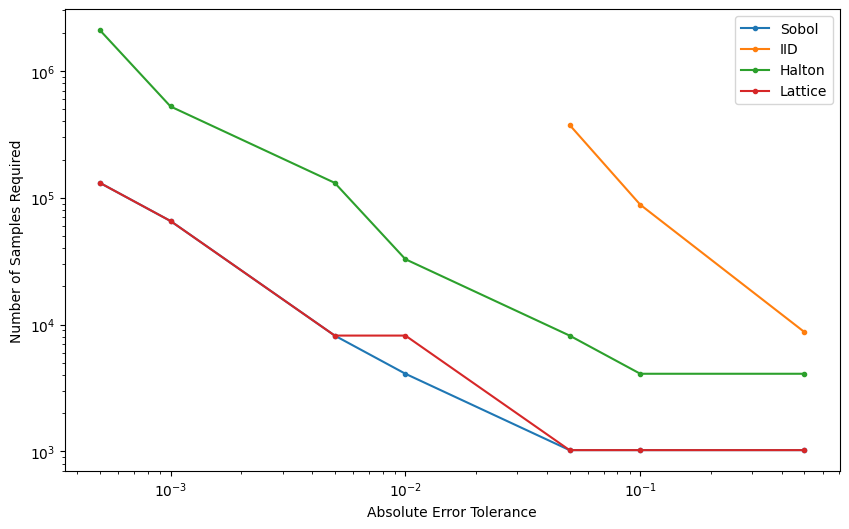

In [7]:
plt.figure(figsize=(10, 6))
plt.loglog(tol_vec,nSobol_required,'.-',label = 'Sobol')
plt.loglog(tol_vec,nIID_required,'.-',label = 'IID')
plt.loglog(tol_vec,nHalton_required,'.-',label = 'Halton')
plt.loglog(tol_vec,nLattice_required,'.-',label = 'Lattice')
plt.xlabel('Absolute Error Tolerance')
plt.ylabel('Number of Samples Required')
plt.legend()
plt.show()

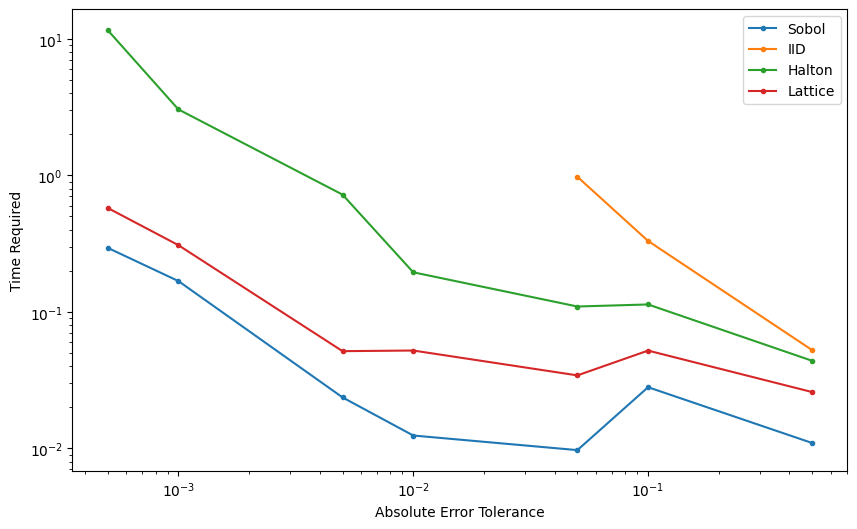

In [8]:
plt.figure(figsize=(10, 6))
plt.loglog(tol_vec,tSobol_required,'.-',label = 'Sobol')
plt.loglog(tol_vec,tIID_required,'.-',label = 'IID')
plt.loglog(tol_vec,tHalton_required,'.-',label = 'Halton')
plt.loglog(tol_vec,tLattice_required,'.-',label = 'Lattice')
plt.xlabel('Absolute Error Tolerance')
plt.ylabel('Time Required')
plt.legend()
plt.show()

In [9]:
!pip install qmcpy